## Use **Fuzzing Book** Resources

Clone the [Fuzzing Book](https://www.fuzzingbook.org/) repository and put this notebook under the directory `fuzzingbook/notebooks/`. Then you can use the fuzzing book resources in this notebook.

In [1]:
import sys
sys.path.append("notebooks/") # add the notebooks directory to the path

import bookutils
from typing import List, Tuple, Dict, Any
from Fuzzer import RandomFuzzer
from html.parser import HTMLParser
from Coverage import Coverage
import pickle
import hashlib

# **1. Preparation**

## 1.1. Define the Problem

Let's say we have many different mutants of a program. We want to generate a test suite that kills mutants. Each mutant is killed by some or no test cases.

Let's consider the test generation process as a sampling process.

- **Each mutant corresponds to a unique color**.
- **Each test case is a ball with zero or more colors on it**: 
  - If a test case kills a mutant, the mutant's color is on the ball.
  - If a test case does not kill a mutant, the mutant's color is not on the ball.

For example, an equivalent mutant, i.e., a mutant with the same behavior as the original program, is a mutant that is not killed by any test case. In this case, the mutant's color is not on any ball.

## 1.2. Sampling Process

To apply the statistical estimator, theoretically, we need the sampling process to be **independent and identically distributed (i.i.d.)**. ***This is a strong assumption.*** What this means is that the probability of our next sampled test case killing a mutant should be the same as the probability of our previous sampled test case killing a mutant. Again, this means

- if you already have a **pre-defined set of test cases** (not has been executed yet), one should choose the next test case from this set **uniformly at random**.
- if you are **generating test cases on the fly**, the **test generation scheme should be independent** of what has been generated so far and the test generation scheme should be the same for all test cases.

The test sampling process being i.i.d. is equivalent to the following: let the probability of killing a mutant $m_i$ of j-th generated test case $t_j$ be $p_{ij}$. Then, **all the $p_{ij}$ for all $j$ are the same**, i.e., $\forall x, y \in \mathbb{N}, p_{ix} = p_{iy}$.

Now, let $p_i$ be the probability of killing mutant $m_i$ by a test case.


## 1.3. Experiment Setup

Let's design an artificial experiment to check how the statistical estimator works.

Let's say we have $M = 1000000$ (1M) mutants. Some mutants are more difficult to kill than others and some mutants are equivalent to the original program, i.e., $p_i = 0$ for some $i$.
Assume that 10% of the mutants are equivalent to the original program, and 90% of the mutants, the killing probability of $i-th$ mutant $p_i$ is $1/i$.
This means that the first mutant is killed by 100% of the test cases, the second mutant is killed by 50% of the test cases, and so on.

$p_i = \begin{cases}
\frac{1}{i} & \text{if } i \leq 900000 \\
0 & \text{if } i > 900000
\end{cases}$

In [3]:
import numpy as np

p_kill = np.array([1 / i for i in range(1, 900001)] + [0] * 100000)
print(f"Number of mutants: {len(p_kill)}")

Number of mutants: 1000000


### The change of the number of mutants killed as the number of test cases increases.

Let's say we will generate up to $N=5000000$ (5M) test cases. The number of mutants killed by $n \le N$ test cases is shown in the following figure.

Test points: [     10      11      13      14      16      19      22      25      28
      32      37      42      49      56      63      73      83      95
     108     124     141     161     184     210     240     274     313
     358     409     467     533     608     695     793     906    1034
    1181    1348    1539    1758    2007    2291    2616    2987    3410
    3894    4446    5076    5796    6617    7555    8626    9849   11245
   12838   14658   16736   19108   21816   24908   28439   32470   37072
   42326   48326   55175   62996   71924   82119   93758  107047  122219
  139542  159320  181901  207683  237119  270727  309098  352909  402928
  460037  525241  599686  684683  781726  892525 1019027 1163459 1328362
 1516637 1731598 1977026 2257240 2577171 2942446 3359494 3835652 4379299
 4999999]


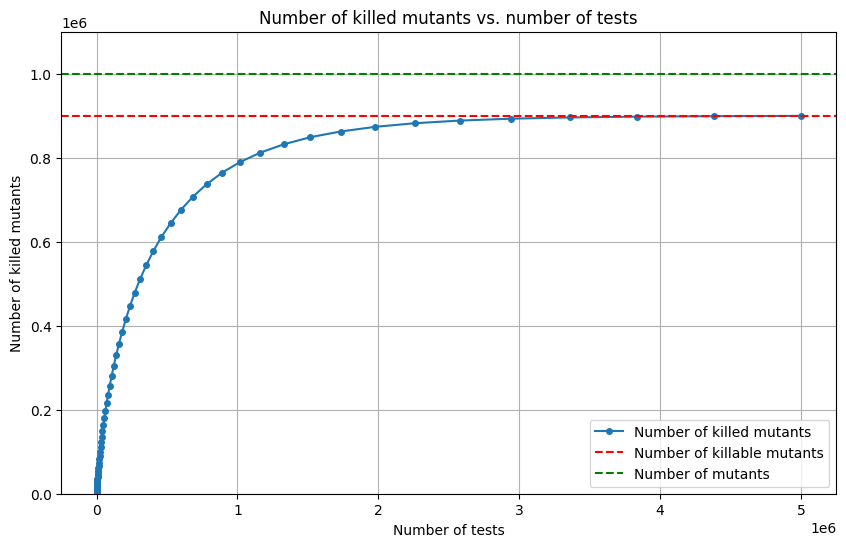

/var/folders/v9/wc5dh1fd691947y71hyt_2280000gn/T/ipykernel_14053/1224288786.py:50: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0, 1100000)


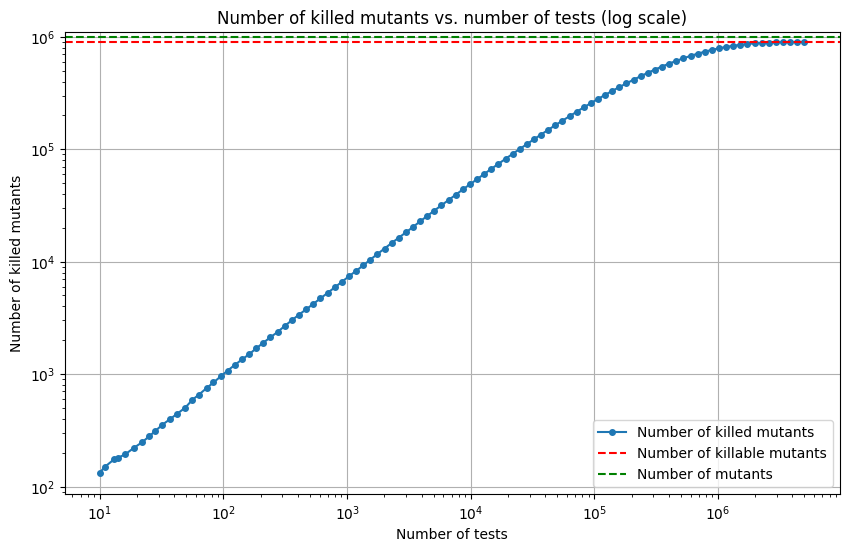

In [68]:
import matplotlib.pyplot as plt

# log scale x
N_test = 5000000
xs = np.floor(np.logspace(1, np.log10(N_test), 100)).astype(int)
print(f"Test points: {xs}")

n_test_prev = 0
cnts_killed = []
total_killed = []
n_singletons = []
n_doubletons = []
for n_test in xs:
    n_test_add = n_test - n_test_prev
    # the number of the mutant i being killed by n_test_add tests follows a
    # binomial distribution with parameters n_test_add and p_kill[i]
    cnt_killed = cnts_killed[-1].copy() if cnts_killed else np.zeros(len(p_kill), dtype=int)
    cnt_killed += np.random.binomial(n_test_add, p_kill)
    cnts_killed.append(cnt_killed)
    # count the non-zero elements in cnt_killed
    total_killed.append(np.count_nonzero(cnt_killed))
    # count the number of singletons
    n_singletons.append(np.count_nonzero(cnt_killed == 1))
    # count the number of doubletons
    n_doubletons.append(np.count_nonzero(cnt_killed == 2))
    n_test_prev = n_test
cnts_killed = np.array(cnts_killed)
ys = np.array(total_killed)

# plot the data
plt.figure(figsize=(10, 6))
plt.plot(xs, ys, marker='o', markersize=4, label="Number of killed mutants")
plt.xlabel("Number of tests")
plt.ylabel("Number of killed mutants")
plt.title("Number of killed mutants vs. number of tests")
plt.ylim(0, 1100000)
plt.axhline(y=900000, color='r', linestyle='--', label="Number of killable mutants")
plt.axhline(y=1000000, color='g', linestyle='--', label="Number of mutants")
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(xs, ys, marker='o', markersize=4, label="Number of killed mutants")
plt.xlabel("Number of tests")
plt.ylabel("Number of killed mutants")
plt.title("Number of killed mutants vs. number of tests (log scale)")
plt.xscale('log')
plt.yscale('log')
plt.ylim(0, 1100000)
plt.axhline(y=900000, color='r', linestyle='--', label="Number of killable mutants")
plt.axhline(y=1000000, color='g', linestyle='--', label="Number of mutants")
plt.legend()
plt.grid()
plt.show()

# **2. Missing Mass**: What is the probability that the next test case kills a mutant that has not been killed yet?

## Good-Turing estimator

$$
\hat{M}_0^{\text{GoodTuring}} = \frac{\Phi_1}{n},
$$

where $\Phi_1$ is the number of singletons.

Let's compare the Good-Turing estimator with the empirical probability estimate.
Given $n \ll N$ test cases, the empirical estimate of the probability of killing a mutant in the next test case is given by
$$
\frac{Kill(N) - Kill(n)}{N - n}
$$
where $Kill(n)$ and $Kill(N)$ are the number of mutants killed by $n$ and $N$ test cases, respectively.

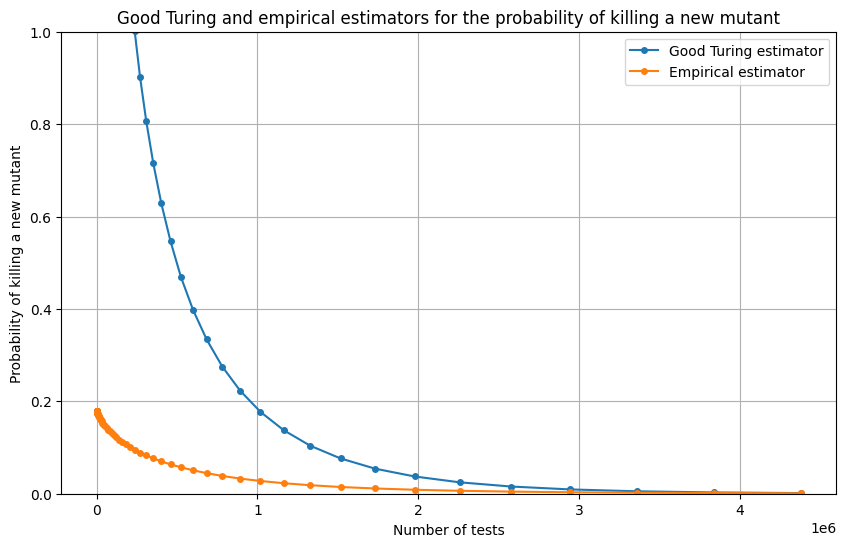

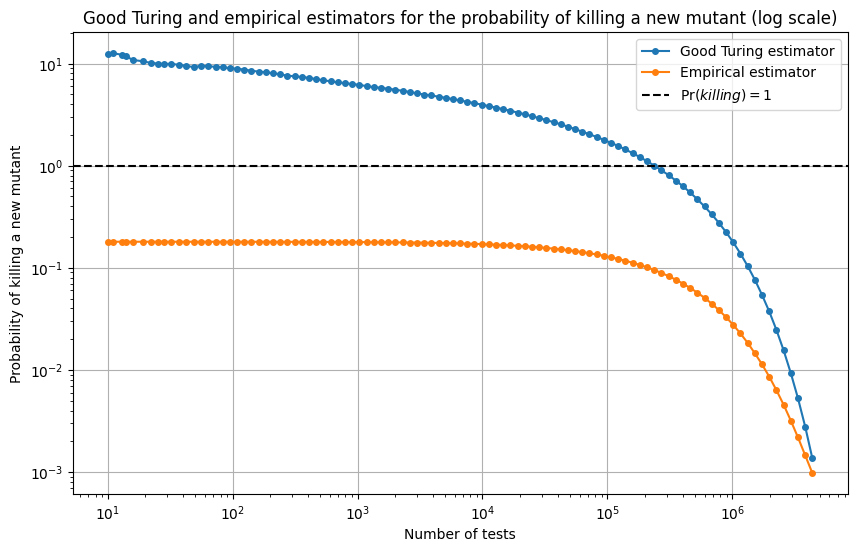

In [ ]:
good_turings = []
empiricals = []
for i in range(len(xs) - 1):
    # good turing estimator
    n_test = xs[i]
    n_singleton = n_singletons[i]
    good_turings.append(n_singleton / n_test)
    # empirical estimator
    n_kill = np.count_nonzero(cnts_killed[i] > 0)
    empirical = (ys[-1] - n_kill) / (N_test - n_test)
    empiricals.append(empirical)

# plot the data
plt.figure(figsize=(10, 6))
plt.plot(xs[:-1], good_turings, label="Good Turing estimator", marker='o', markersize=4)
plt.plot(xs[:-1], empiricals, label="Empirical estimator", marker='o', markersize=4)
plt.xlabel("Number of tests")
plt.ylabel("Probability of killing a new mutant")
plt.title("Good Turing and empirical estimators for the probability of killing a new mutant")
plt.ylim(0, 1)
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(xs[:-1], good_turings, label="Good Turing estimator", marker='o', markersize=4)
plt.plot(xs[:-1], empiricals, label="Empirical estimator", marker='o', markersize=4)
plt.xlabel("Number of tests")
plt.ylabel("Probability of killing a new mutant")
plt.title("Good Turing and empirical estimators for the probability of killing a new mutant (log scale)")
plt.xscale('log')
plt.yscale('log')
plt.axhline(y=1, color='black', linestyle='--', label=r"$\Pr(killing) = 1$")
plt.legend()
plt.grid()
plt.show()

# **3. Species Richness**: What is the number of mutants that have not been killed yet?

## Chao1 estimator

Chao1 estimator computes the lower bound of the number of killable mutants remaining in the population.

$$
\hat{C} = \begin{cases}
\frac{n - 1}{n} \cdot \frac{\Phi_1^2}{2 \Phi_2} & \text{if } \Phi_2 > 0 \\
\frac{n - 1}{n} \cdot \frac{\Phi_1(\Phi_1 - 1)}{2} & \text{if } \Phi_2 = 0
\end{cases}
$$

where $\Phi_1$ is the number of singletons and $\Phi_2$ is the number of doubletons.

The ground truth of the number of killable mutants is $900000 - Kill(n)$, where $Kill(n)$ is the number of mutants killed by $n$ test cases.

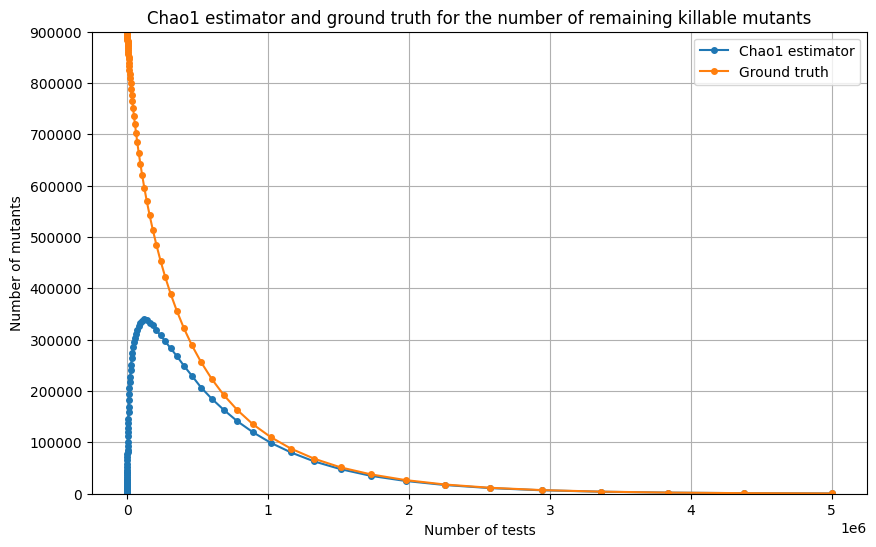

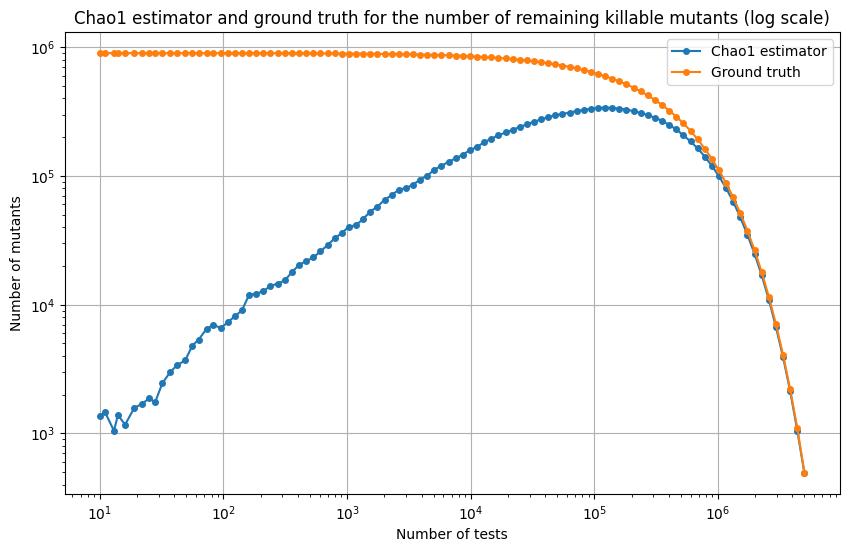

In [75]:
chao1s = []
groundtruths = []

for i in range(len(xs)):
    # chao1 estimator
    n_test = xs[i]
    n_singleton = n_singletons[i]
    n_doubleton = n_doubletons[i]
    if n_doubleton > 0:
        chao1 = (n_test - 1) / n_test * n_singleton ** 2 / (2 * n_doubleton)
    else:
        chao1 = (n_test - 1) / n_test * n_singleton * (n_singleton - 1) / 2
    chao1s.append(chao1)
    # ground truth
    groundtruth = 900000 - np.count_nonzero(cnts_killed[i] > 0)
    groundtruths.append(groundtruth)

# plot the data
plt.figure(figsize=(10, 6))
plt.plot(xs, chao1s, label="Chao1 estimator", marker='o', markersize=4)
plt.plot(xs, groundtruths, label="Ground truth", marker='o', markersize=4)
plt.xlabel("Number of tests")
plt.ylabel("Number of mutants")
plt.title("Chao1 estimator and ground truth for the number of remaining killable mutants")
plt.ylim(0, 900000)
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(xs, chao1s, label="Chao1 estimator", marker='o', markersize=4)
plt.plot(xs, groundtruths, label="Ground truth", marker='o', markersize=4)
plt.xlabel("Number of tests")
plt.ylabel("Number of mutants")
plt.title("Chao1 estimator and ground truth for the number of remaining killable mutants (log scale)")
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.grid()
plt.show()

# **4. Extrapolation**: How many more mutants can I kill with $m$ more test cases?

- $\Delta(m)$: the number of new discoveries when $m$ more samples are retrieved.

$$
\hat \Delta(m) = \hat \Phi_0 \left[1 - \left(1 - \frac{\Phi_1}{n\hat \Phi_0 + \Phi_1} \right)^m\right]
$$

where $\hat \Phi_0$ is the estimated number of killable mutants (e.g., Chao1 estimator). Here, I'll think of three cases for $\hat \Phi_0$:
1) use Chao1 estimator
2) use total number of mutants ($M$): $1000000 - Kill(n)$
3) use the ground truth: $900000 - Kill(n)$

The empirical estimate of the number of new discoveries is given by
$$Kill(n + m) - Kill(m)$$
where $Kill(n)$ and $Kill(m)$ are the number of mutants killed by $n$ and $m$ test cases, respectively.

I will consider multiple values of $n$.

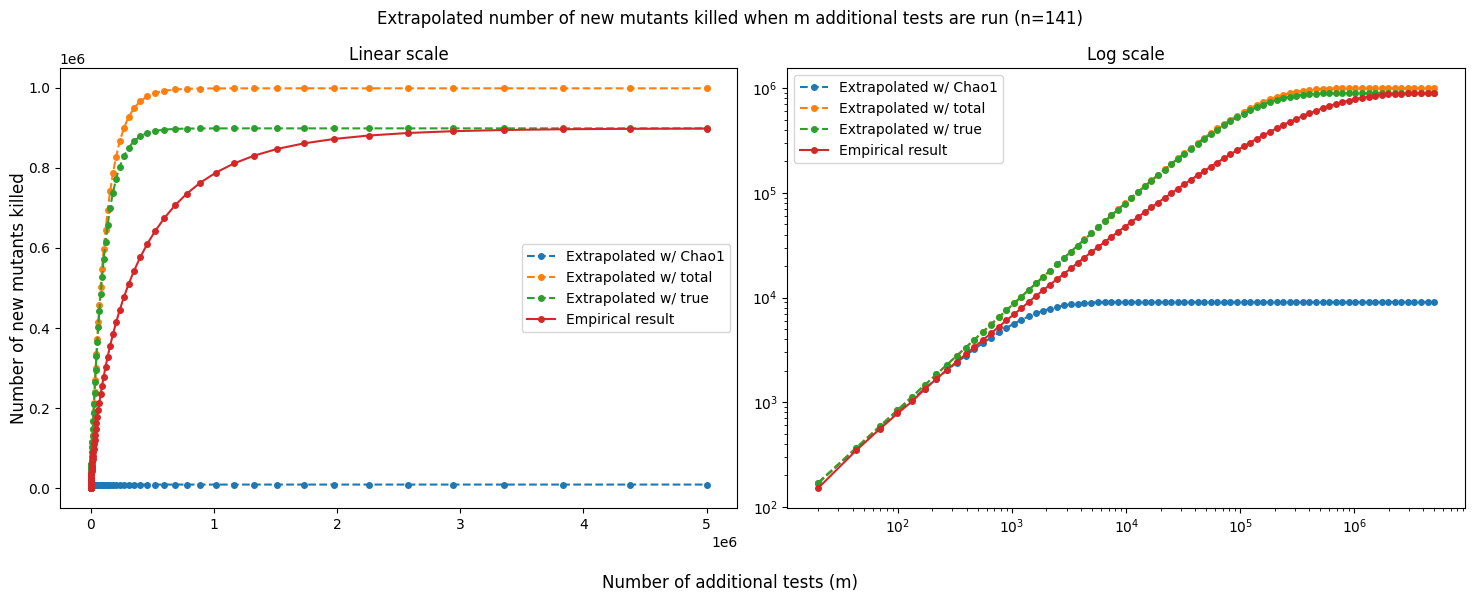

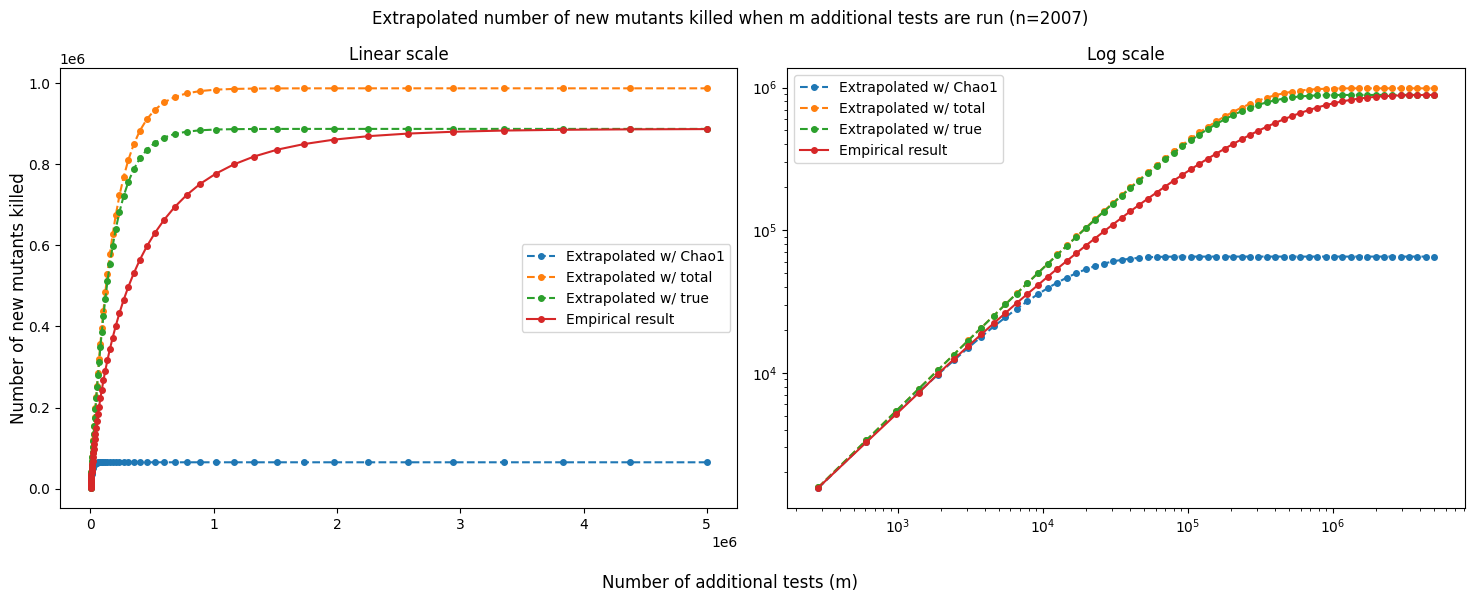

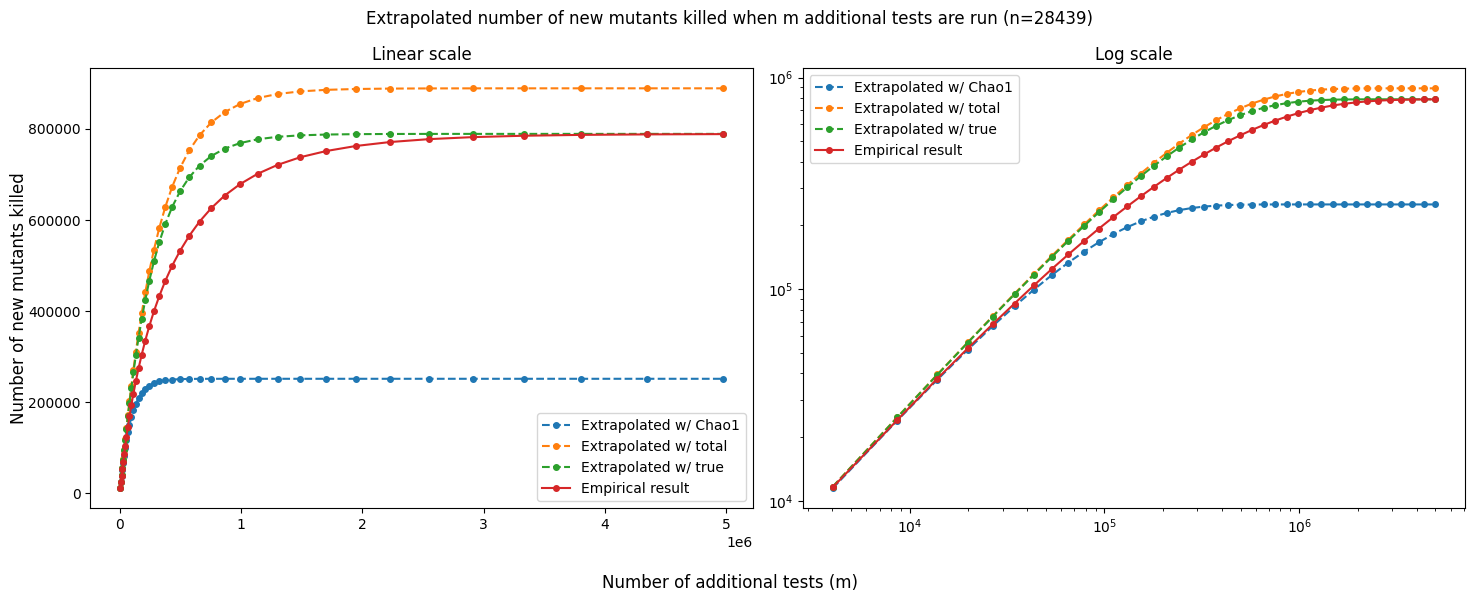

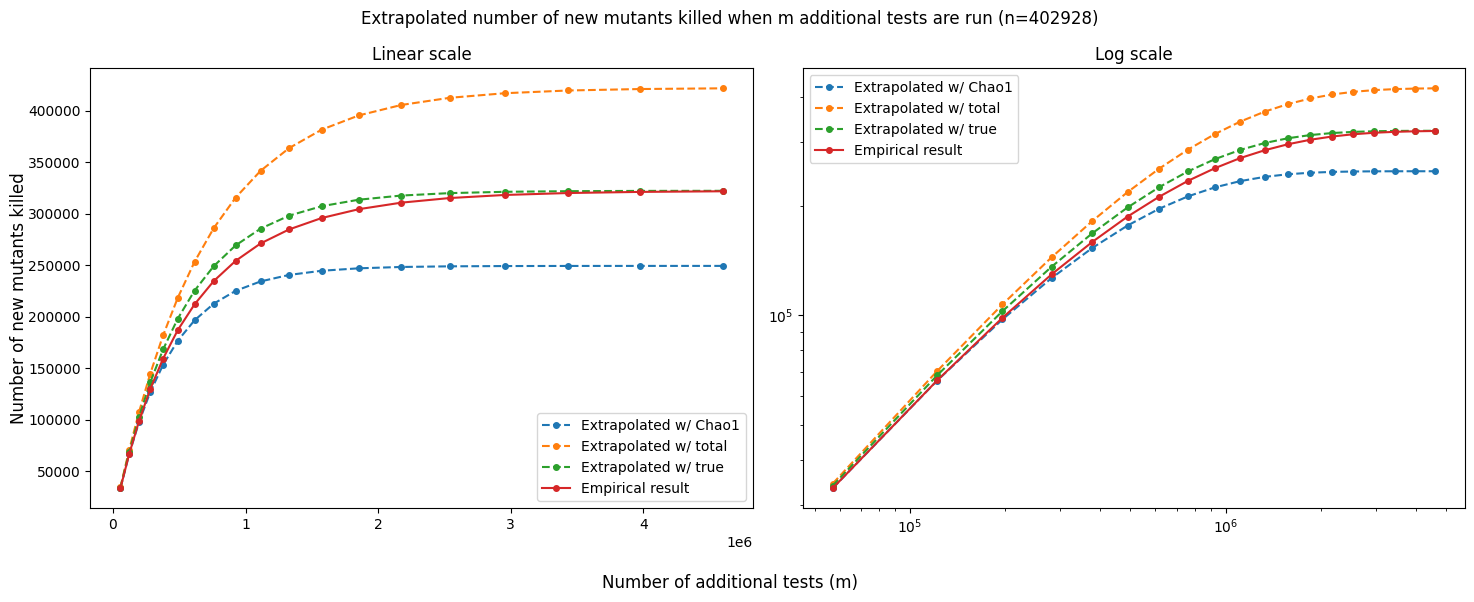

In [101]:
for i_n in [20, 40, 60, 80]:
# i_n = 80
    n_test = xs[i_n]
    n_singleton = n_singletons[i_n]
    n_kill = np.count_nonzero(cnts_killed[i_n] > 0)
    phi0_chao = chao1s[i_n]
    phi0_total = 1000000 - np.count_nonzero(cnts_killed[i_n] > 0)
    phi0_true = 900000 - np.count_nonzero(cnts_killed[i_n] > 0)

    extra_chaos = []
    extra_totals = []
    extra_trues = []
    extra_empiricals = []
    for i in range(i_n + 1, len(xs)):
        m = xs[i] - n_test
        extra_chao = phi0_chao * (1 - (1 - n_singleton / (n_test * phi0_chao + n_singleton)) ** m)
        extra_chaos.append(extra_chao)
        extra_total = phi0_total * (1 - (1 - n_singleton / (n_test * phi0_total + n_singleton)) ** m)
        extra_totals.append(extra_total)
        extra_true = phi0_true * (1 - (1 - n_singleton / (n_test * phi0_true + n_singleton)) ** m)
        extra_trues.append(extra_true)
        extra_empirical = np.count_nonzero(cnts_killed[i] > 0) - n_kill
        extra_empiricals.append(extra_empirical)

    # plot the data
    # plt.figure(figsize=(10, 6))
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    # axes[0] is linear scale
    axes[0].plot(xs[i_n + 1:] - n_test, extra_chaos, label="Extrapolated w/ Chao1", marker='o', markersize=4, linestyle='--')
    axes[0].plot(xs[i_n + 1:] - n_test, extra_totals, label="Extrapolated w/ total", marker='o', markersize=4, linestyle='--')
    axes[0].plot(xs[i_n + 1:] - n_test, extra_trues, label="Extrapolated w/ true", marker='o', markersize=4, linestyle='--')
    axes[0].plot(xs[i_n + 1:] - n_test, extra_empiricals, label="Empirical result", marker='o', markersize=4)
    axes[0].legend()
    axes[0].set_title("Linear scale")
    # axes[1] is log scale
    axes[1].plot(xs[i_n + 1:] - n_test, extra_chaos, label="Extrapolated w/ Chao1", marker='o', markersize=4, linestyle='--')
    axes[1].plot(xs[i_n + 1:] - n_test, extra_totals, label="Extrapolated w/ total", marker='o', markersize=4, linestyle='--')
    axes[1].plot(xs[i_n + 1:] - n_test, extra_trues, label="Extrapolated w/ true", marker='o', markersize=4, linestyle='--')
    axes[1].plot(xs[i_n + 1:] - n_test, extra_empiricals, label="Empirical result", marker='o', markersize=4)
    axes[1].set_yscale('log')
    axes[1].set_xscale('log')
    axes[1].set_title("Log scale")
    axes[1].legend()
    fig.suptitle(f"Extrapolated number of new mutants killed when m additional tests are run (n={n_test})")
    fig.supxlabel("Number of additional tests (m)")
    fig.supylabel("Number of new mutants killed")
    fig.tight_layout()
    plt.show()